In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from malan_net import MalanNet
from IPython.display import clear_output, display

In [0]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 0.005
BATCH_SIZE = 32
EPOCH_SIZE = 50

In [0]:
X = pd.read_csv('dataset.csv')
X = X.iloc[:, 1:].values

In [56]:
X = X[-2583 * 2:]
X.shape

(5166, 1025)

In [57]:
np.random.shuffle(X)
Y = X[:, -1].reshape(-1, 1)
X = X[:, :-1].reshape((-1, 1, 32, 32))
print(X.shape, Y.shape)

TRAIN_X = X[:2583]
TRAIN_Y = Y[:2583]

TEST_X = X[2583:]
TEST_Y = Y[2583:]

TRAIN_X = torch.from_numpy(TRAIN_X).to(DEVICE)
TRAIN_Y = torch.from_numpy(TRAIN_Y).to(DEVICE)

TEST_X = torch.from_numpy(TEST_X).to(DEVICE)
TEST_Y = torch.from_numpy(TEST_Y).to(DEVICE)
del X
del Y

(5166, 1, 32, 32) (5166, 1)


In [0]:
model = MalanNet().to(DEVICE)
lossfn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=LR)
def accfn(h, y):
  return torch.sum((h > 0.5) == (y > 0.5)) / float(h.shape[0]) * 100

In [0]:
def run_model(train_x, train_y, test_x, test_y, epoch_size, batch_size):
    train_losses = torch.tensor(()).to(DEVICE)
    train_accs = torch.tensor(()).to(DEVICE)
    test_losses = torch.tensor(()).to(DEVICE)
    test_accs = torch.tensor(()).to(DEVICE)

    for epoch in range(EPOCH_SIZE):
        train_perm = torch.randperm(train_x.shape[0])
        model.train()
        for batch_idx in range(0, train_x.shape[0], batch_size):
            idxs = train_perm[batch_idx:batch_idx + batch_size]
            batch_x, batch_y = train_x[idxs], train_y[idxs]
            optimizer.zero_grad()
            batch_h = model(batch_x.float())
            loss = lossfn(batch_h.float(), batch_y.float())
            acc = accfn(batch_h.float(), batch_y.float())
            train_losses = torch.cat((train_losses, loss.view(1)))
            train_accs = torch.cat((train_accs, acc.view(1)))
            loss.backward() 
            optimizer.step()
        model.eval()
        test_perm = torch.randperm(test_x.shape[0])
        with torch.no_grad():
            for batch_idx in range(0, test_x.shape[0], batch_size):
                idxs = test_perm[batch_idx:batch_idx + batch_size]
                batch_x, batch_y = test_x[idxs], test_y[idxs]
                batch_h = model(batch_x.float())
                loss = lossfn(batch_h.float(), batch_y.float())
                acc = accfn(batch_h.float(), batch_y.float())
                test_losses = torch.cat((test_losses, loss.view(1)))
                test_accs = torch.cat((test_accs, acc.view(1)))
        print('epoch', epoch)
        clear_output(wait=True)

    return train_losses, train_accs, test_losses, test_accs

In [60]:
train_losses, train_accs, test_losses, test_accs = run_model(TRAIN_X, TRAIN_Y, TEST_X, TEST_Y, EPOCH_SIZE, BATCH_SIZE)

epoch 49


In [0]:
train_losses = train_losses.detach().numpy()
test_losses = test_losses.detach().numpy()
train_accs = train_accs.detach().numpy()
test_accs = test_accs.detach().numpy()

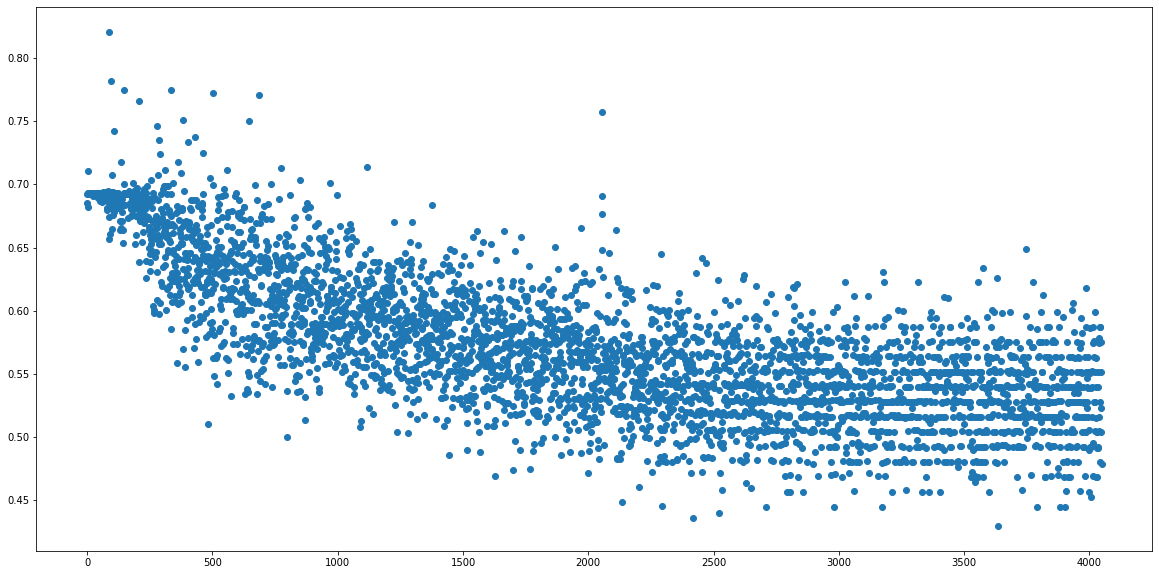

In [62]:
plt.figure(figsize=(20, 10))
plt.scatter(np.arange(train_losses.shape[0]), train_losses)

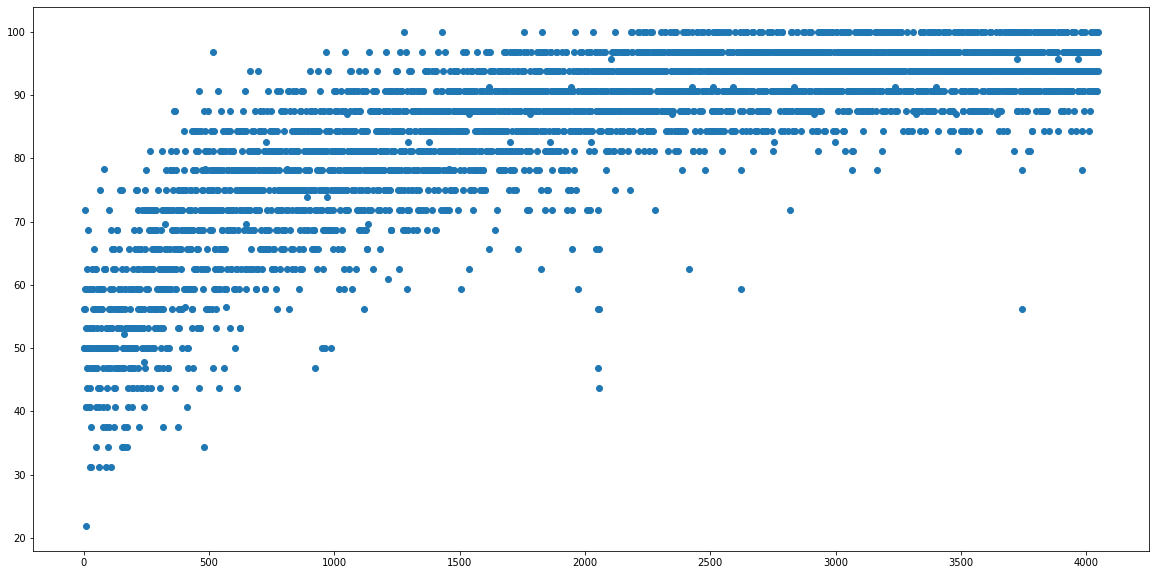

In [63]:
plt.figure(figsize=(20, 10))
plt.scatter(np.arange(train_accs.shape[0]), train_accs)

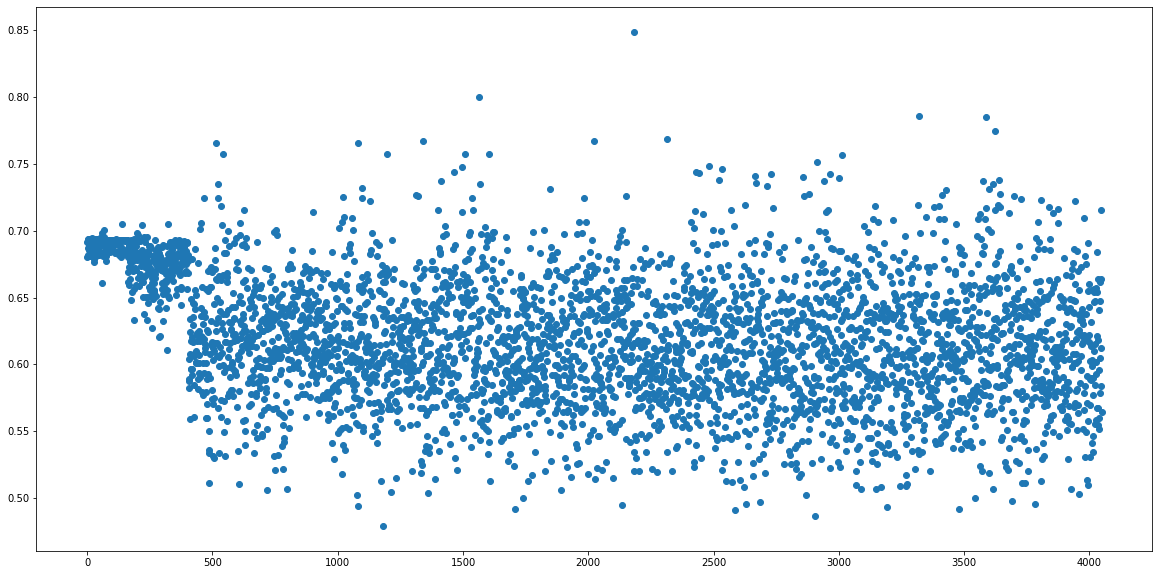

In [64]:
plt.figure(figsize=(20, 10))
plt.scatter(np.arange(test_losses.shape[0]), test_losses)

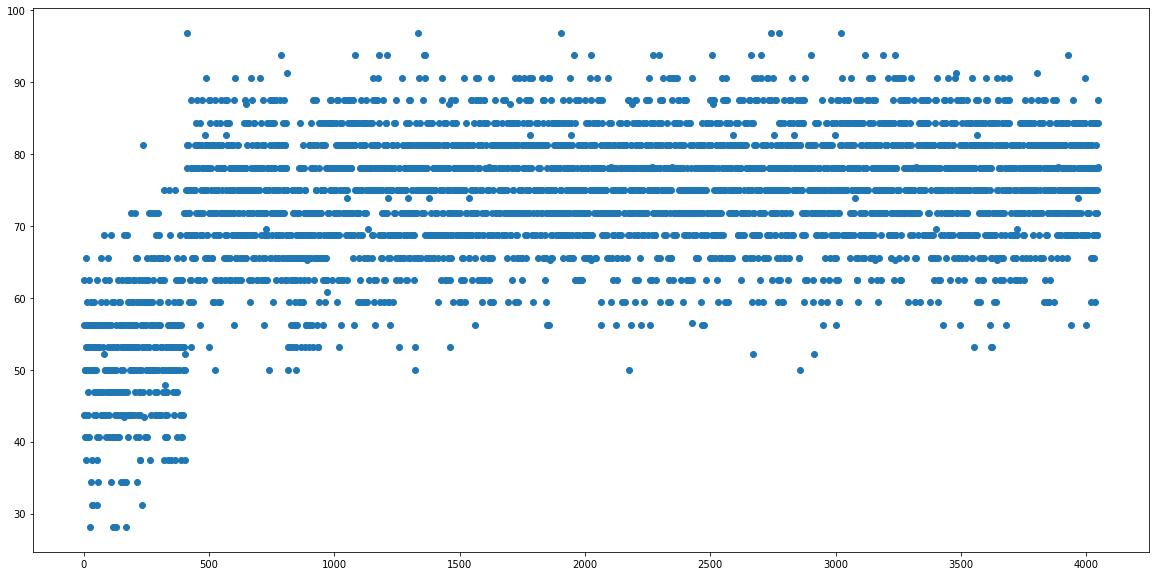

In [65]:
plt.figure(figsize=(20, 10))
plt.scatter(np.arange(test_accs.shape[0]), test_accs)

In [66]:
print('final test loss', test_losses.sum() / test_losses.shape[0], 'final test acc', test_accs.sum() / test_accs.shape[0])

final test loss 0.6198206018518518 final test acc 72.96010802469135


In [0]:
torch.save({'state_dict': model.state_dict()}, 'checkpoint.pth')